# **Churn Prediction Using XGBoost**
In this notebook we will explain;


1.   Preparation of our data so it could work on our machine
2.   Training our model and Using GridSearchCV to hypermaximize our models parameters
3.   Evaluate our model
4.   Runing our model and getting results
5.   Metrics and Feature Importance of our model



Before that we have to do 2 things:


1.   Get our dataset and libaries
2.   Process the data




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

df=pd.read_csv('Churn_Modelling.csv')

In [3]:
# Basic preprocessing
def preprocess_bank_data(df):
    # Create a copy
    df_clean = df.copy()

    # Verify required columns exist
    required_columns = ['Geography', 'Gender', 'CreditScore', 'Age', 'Tenure',
                       'Balance', 'NumOfProducts', 'EstimatedSalary']
    missing_cols = [col for col in required_columns if col not in df_clean.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")


    # Convert categorical variables
    geography_dummies = pd.get_dummies(df_clean['Geography'], prefix='Geography')
    df_clean = df_clean.drop('Geography', axis=1)
    df_clean = pd.concat([df_clean, geography_dummies], axis=1)

    # Convert Gender with error handling
    gender_map = {'Female': 0, 'Male': 1}
    if not df_clean['Gender'].isin(gender_map.keys()).all():
        raise ValueError("Unknown gender categories found in data")
    df_clean['Gender'] = df_clean['Gender'].map(gender_map)

    # Scale numerical features
    scaler = StandardScaler()
    numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance',
                     'NumOfProducts', 'EstimatedSalary']
    df_clean[numerical_cols] = scaler.fit_transform(df_clean[numerical_cols])

    return df_clean

# Preprocess the data
df_processed = preprocess_bank_data(df)

# 1. Preparation of our data

Our model does feature based prediction so preparing our dataset and getting proper collums are very important by that we will filter out non feature collumns after that we will define futures and target

Lastly we will split data for %80 for train %20 for test with 42 random state


In [4]:
def prepare_data(df_processed):
    """Prepare data for XGBoost model"""
    # Remove non-feature columns
    feature_df = df_processed.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

    # Prepare features and target
    X = feature_df
    y = df_processed['Exited']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    return X_train, X_test, y_train, y_test, feature_df.columns

# 2.Trainin Our Model and Hypermeter Tuning

   In this part we will start training our XGBoost model.We will give
first give example parameters grids for tuning so gridsearch performs on these samples after that we will initialize base model. We will
save the best parameters and best ROC score.

In [5]:
def train_xgboost_model(X_train, y_train):
    """Train XGBoost model with hyperparameter tuning"""
    # Define parameter grid for tuning
    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'min_child_weight': [1, 3],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    }

    # Initialize base model
    base_model = xgb.XGBClassifier(
      objective='binary:logistic',
      random_state=42,
      eval_metric='logloss'
)


    # Perform grid search
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("\nBest parameters:", grid_search.best_params_)
    print("Best ROC-AUC score:", grid_search.best_score_)

    return grid_search.best_estimator_

# 3. Evaluating Our Model And Getting Results
In this section we will:


1.   Make predictions
2.   Get the metrics like F1 with classification_report
3.   Get ROC-AUC scores
4.   Perform 5 flod Cross Validation using ROC-AUC values this will help for assessing model's generalization ability



In [6]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance"""
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Calculate and print ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC-AUC Score: {roc_auc:.3f}")

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"\nCross-validation ROC-AUC scores: {cv_scores}")
    print(f"Average CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    return y_pred, y_pred_proba

# 4.Getting result visuals and Feature Importance
After evaluation we will see if our models confusion matrix and Feature Importance.

In [7]:
def plot_feature_importance(model, feature_names):
    """Plot feature importance"""
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    importance_df = importance_df.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Feature Importance in XGBoost Model')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_test, y_pred):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 5.Running our model(Main Execution)
After looking at the metrics and hypertuning we will run our model. We will first train then evaluate our model after that we will plot the results,Importance parameters and confusion matrix.

Training XGBoost model with hyperparameter tuning...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Best ROC-AUC score: 0.8667864125357552

Evaluating model performance...

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.49      0.61       407

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000


ROC-AUC Score: 0.869

Cross-validation ROC-AUC scores: [0.85921835 0.86938149 0.84818359 0.87685277 0.88029587]
Average CV ROC-AUC: 0.867 (+/- 0.024)

Generating visualizations...


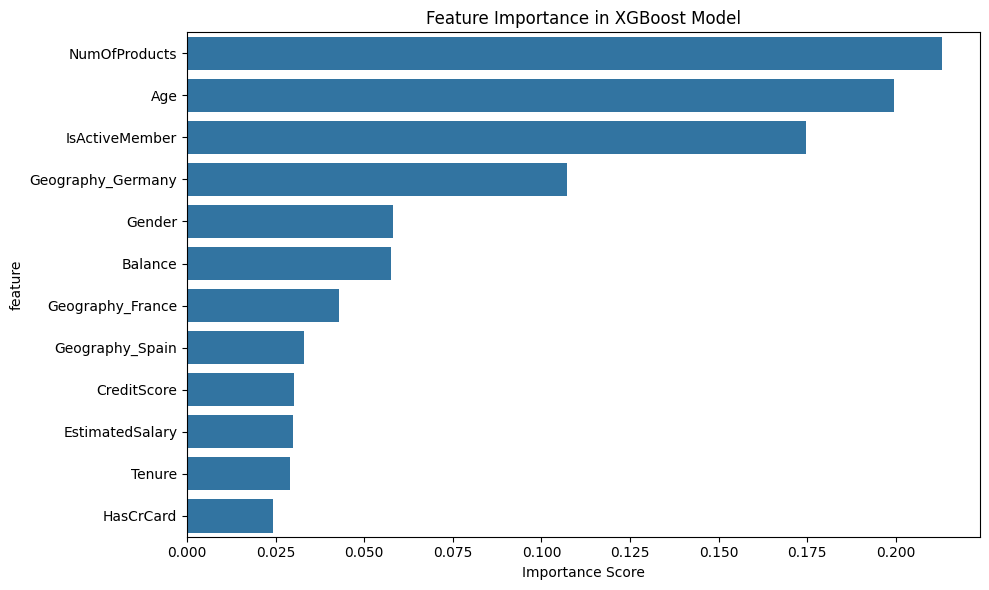

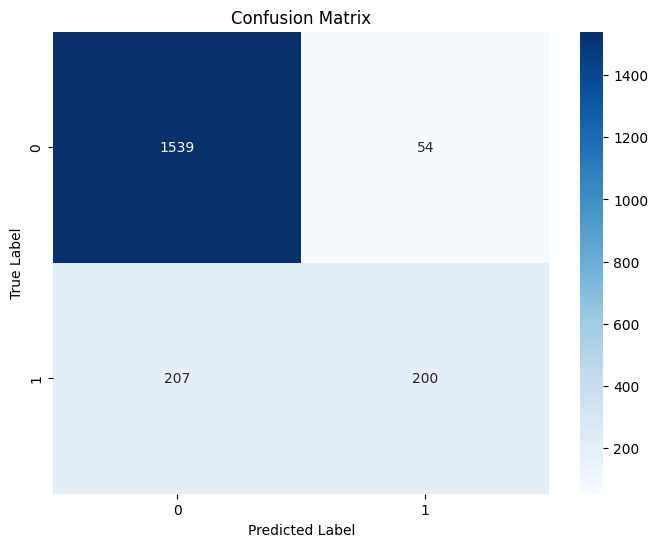

In [8]:
# Main execution
def run_xgboost_analysis(df_processed):
    # Prepare data
    X_train, X_test, y_train, y_test, feature_names = prepare_data(df_processed)

    # Train model
    print("Training XGBoost model with hyperparameter tuning...")
    model = train_xgboost_model(X_train, y_train)

    # Evaluate model
    print("\nEvaluating model performance...")
    y_pred, y_pred_proba = evaluate_model(model, X_train, X_test, y_train, y_test)

    # Plot results
    print("\nGenerating visualizations...")
    plot_feature_importance(model, feature_names)
    plot_confusion_matrix(y_test, y_pred)

    return model, y_pred, y_pred_proba

# Run the analysis
model, y_pred, y_pred_proba = run_xgboost_analysis(df_processed)